In [1]:
import anndata as ad
import pandas as pd
import shapely
import shapely.plotting as splot
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

import ccf_plots as cplot
import ccf_polygons as cpoly
# import ccf_cells

%matplotlib inline

# Load brain3 data

In [2]:
adata = ad.read_h5ad("../data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad")
adata

AnnData object with n_obs × n_vars = 191578 × 550
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    u

# Calculate CCF polygons

In [3]:
# nice to have everything for plotting in the obs dataframe
adata.obs['cirro_x'] = adata.obsm['spatial_cirro'][:,0]
adata.obs['cirro_y'] = adata.obsm['spatial_cirro'][:,1]

In [4]:
ccf_polygons = cpoly.get_ccf_polygons(adata.obs)
ccf_polygons_th_zi = ccf_polygons[ccf_polygons.index.isin(cpoly.CCF_TH_NAMES, level="name")]

In [5]:
ccf_names_noZI = cpoly.CCF_TH_NAMES[:-1]
ccf_polygons_th_noZI = ccf_polygons[ccf_polygons.index.isin(ccf_names_noZI, level="name")]

1199651024


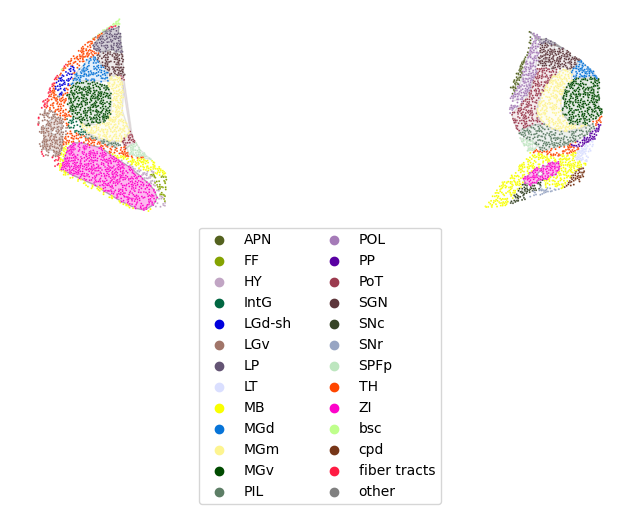

1199651036


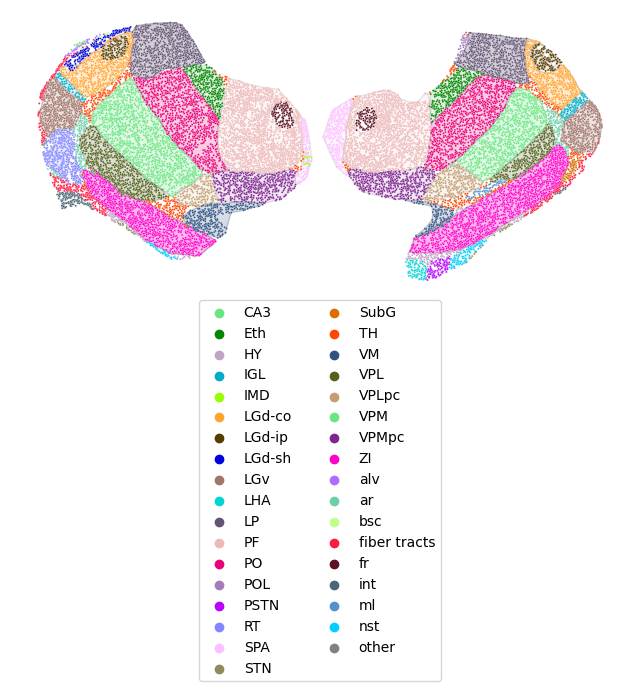

1199651048


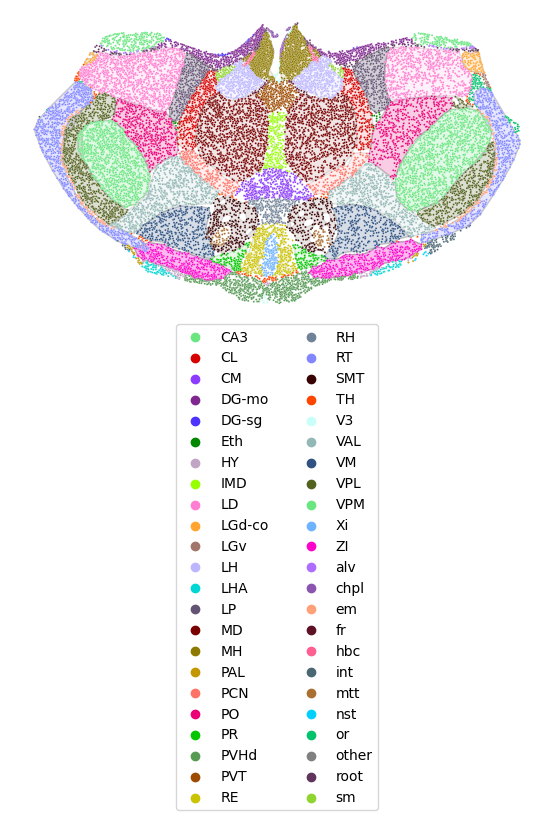

In [6]:
sections = ["1199651024", "1199651036", "1199651048"]
cplot.plot_ccf_overlay(adata.obs, ccf_polygons_th_zi, sections=sections)

In [7]:
# subset just the neurons
divisions_neuron = ['1 Pallium glutamatergic',
                    '2 Subpallium GABAergic',
                    '3 PAL-sAMY-TH-HY-MB-HB neuronal',
                    '4 CBX-MOB-other neuronal']

adata_neurons = adata[adata.obs['division_id_label'].isin(divisions_neuron)]

# Per Subregion Metrics (neurons only)

In [8]:
# only look at the thalamic subregions as defined in cpoly.CCF_TH_NAMES
adata_neurons_ccf = adata_neurons[adata_neurons.obs.CCF_acronym.isin(cpoly.CCF_TH_NAMES)]
adata_neurons_ccf.obs.CCF_acronym.cat.categories

Index(['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'Eth', 'FF', 'IAD', 'IAM', 'IGL',
       'IMD', 'IntG', 'LD', 'LGd-co', 'LGd-ip', 'LGd-sh', 'LGv', 'LH', 'LP',
       'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL', 'PP',
       'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFp',
       'SubG', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi', 'ZI'],
      dtype='object')

In [9]:
# adata_neurons_ccf.obs.subclass_id_label

In [10]:
# define a new df in which to store metrics
th_metrics = pd.DataFrame(index=cpoly.CCF_TH_NAMES)

## Cell Type Richness

transcriptomic richness = \# of (clusters/supertypes/subclasses/classes) present in a given subregion of the thalamus

(Defined similarly to ecology's "species richness" = # of species in a given region)

In [11]:
# generate lists of the clusters, supertypes, subclasses, and classes present
# in the thalamus data
th_clusters = adata_neurons_ccf.obs.cluster_label.drop_duplicates().tolist()
th_supertypes = adata_neurons_ccf.obs.supertype_id_label.drop_duplicates().tolist()
th_subclasses = adata_neurons_ccf.obs.subclass_id_label.drop_duplicates().tolist()
n_th_clusters = len(th_clusters)
n_th_supertypes = len(th_supertypes)
n_th_subclasses = len(th_subclasses)
# print(f'{len(th_clusters)=}')
# print(f'{len(adata_neurons_ccf.obs.cluster_label.unique().tolist())}')
# print(f'{len(th_supertypes)=}')
# print(f'{len(adata_neurons_ccf.obs.supertype_id_label.unique().tolist())}')
# print(f'{len(th_subclasses)=}')
# print(f'{len(adata_neurons_ccf.obs.subclass_id_label.unique().tolist())}')

In [12]:
for subregion, df in adata_neurons_ccf.obs.groupby('CCF_acronym'):
    # number of thalamic clusters, supertypes, subclasses in each subregion
    th_metrics.loc[subregion, 
                   'n_clusters'] = len(df.cluster_label.drop_duplicates())
    th_metrics.loc[subregion, 
                   'n_supertypes'] = len(df.supertype_id_label.drop_duplicates())
    th_metrics.loc[subregion, 
                   'n_subclasses'] = len(df.subclass_id_label.drop_duplicates())

    # fraction of thalamic clusters, supertypes, subclasses in each 
    # subregion (denominator is total # of [tax. level] present in all of thalamus)
    th_metrics.loc[subregion, 
                   'frac_clusters'] = (len(df.cluster_label.drop_duplicates()) 
                                       / n_th_clusters)
    th_metrics.loc[subregion,
                   'frac_supertypes'] = (len(df.supertype_id_label.drop_duplicates())
                                         / n_th_supertypes)
    th_metrics.loc[subregion,
                   'frac_subclasses'] = (len(df.subclass_id_label.drop_duplicates())
                                         / n_th_subclasses)

### scatter plot

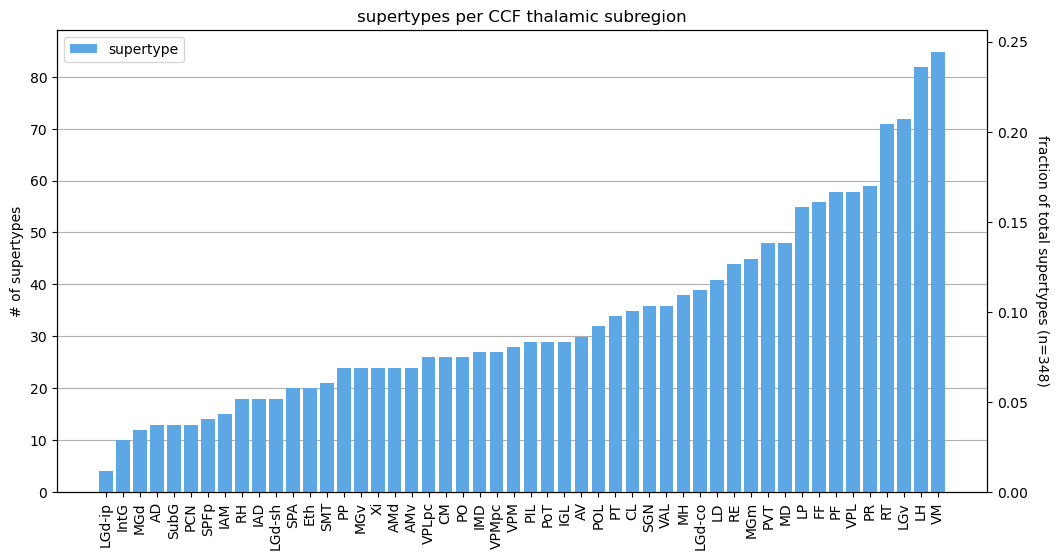

In [13]:
# exlcude ZI because it's so much higher
th_metrics_noZI = th_metrics.loc[ccf_names_noZI]
th_metrics_sorted = th_metrics_noZI.sort_values(by='frac_supertypes', ascending=True)
# th_metrics_sorted

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the absolute values on the left y-axis
ax1.scatter(th_metrics_sorted.index, th_metrics_sorted['n_supertypes'], color='#5DA7E5', alpha=0)
ax1.set_ylabel('# of supertypes', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xticks(th_metrics_sorted.index)
ax1.set_xticklabels(th_metrics_sorted.index, rotation=90)
plt.grid(visible=True, axis='y')

# Create a secondary y-axis on the right
ax2 = ax1.twinx()

# Plot the fraction values on the right y-axis
ax2.bar(th_metrics_sorted.index, th_metrics_sorted['frac_supertypes'], color='#5DA7E5', label='supertype')
ax2.set_ylabel('fraction of total supertypes (n='+str(n_th_supertypes)+')', color='k', rotation=270, labelpad=15)
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend()

# plt.xticks(rotation=90)
plt.xlabel('CCF thalamic subregions')
plt.title('supertypes per CCF thalamic subregion')

plt.show()

### CCF colored by value

Supertypes
1199651048


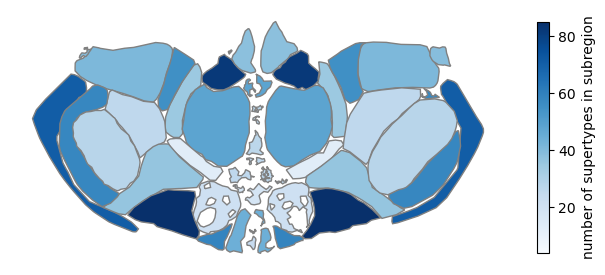

In [14]:
sections = ['1199651048'] #["1199651036", "1199651048", "1199651060"] #"1199651024",
print('Supertypes')
cplot.plot_metrics_ccf(adata_neurons_ccf.obs, ccf_polygons_th_noZI, 
                       th_metrics.loc[ccf_names_noZI,'n_supertypes'], 
                       sections=sections, cmap='Blues',
                       highlight='all', cb_label='number of supertypes in subregion')

Clusters
1199651048


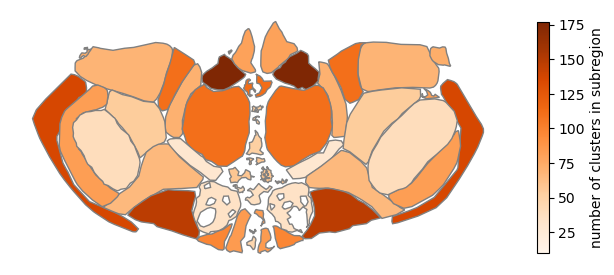

In [15]:
sections = ['1199651048'] #["1199651036", "1199651048", "1199651060"] #"1199651024",
print('Clusters')
cplot.plot_metrics_ccf(adata_neurons_ccf.obs, ccf_polygons_th_noZI,
                       th_metrics.loc[ccf_names_noZI,'n_clusters'], 
                       sections=sections,  cmap='Oranges',
                       highlight='all', cb_label='number of clusters in subregion')

## Cell Type Diversity

### Shannon Diversity Index

In [16]:
# Shannon diversity index, normalized to (0,1)
# 1 = high diversity (clusters found in equal proportions)
# 0 = low diversity (some clusters found in higher proportions in subregion)

def calc_shannon_index(obs_col, n_total_categories):
    # calculate proportion of each category
    cateogory_counts = obs_col.value_counts()
    cateogory_counts = cateogory_counts[cateogory_counts>0] # cleanup zeros so log() doesn't throw warnings
    p = cateogory_counts / cateogory_counts.sum()
    
    # calculate shannon diversity index
    shannon_ind = (-1)*((p * np.log2(p)).sum())
    
    # normalize by log2 of number of categories to limit index to range (0, 1)
    shannon_norm = shannon_ind / np.log2(n_total_categories)
    
    return shannon_norm

In [17]:
# clusters
for subregion, df in adata_neurons_ccf.obs.groupby('CCF_acronym'):
    th_metrics.loc[subregion, 
                   'shannon_index_clusters'] = calc_shannon_index(df['cluster_label'], 
                                                                  n_th_clusters)
    th_metrics.loc[subregion, 
                   'shannon_index_supertypes'] = calc_shannon_index(df['supertype_id_label'], 
                                                                  n_th_clusters)
    th_metrics.loc[subregion, 
                   'shannon_index_subclasses'] = calc_shannon_index(df['subclass_id_label'], 
                                                                  n_th_clusters)

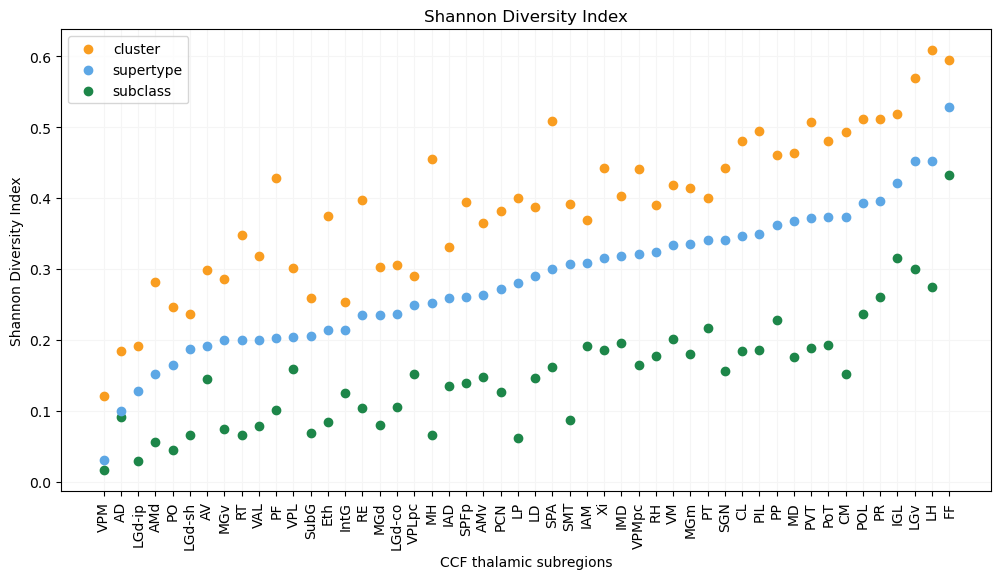

In [18]:
# exlcude ZI because it's so much higher
th_metrics_noZI = th_metrics.loc[ccf_names_noZI]

# sort by cluster shannon index
th_metrics_sorted = th_metrics_noZI.sort_values(by='shannon_index_supertypes', ascending=True)
# th_metrics_sorted

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the absolute values on the left y-axis
ax1.scatter(th_metrics_sorted.index, th_metrics_sorted['shannon_index_clusters'], 
            color='#F99D20', label='cluster', zorder=2) # orange
ax1.scatter(th_metrics_sorted.index, th_metrics_sorted['shannon_index_supertypes'], 
            color='#5DA7E5', label='supertype', zorder=3) # blue
ax1.scatter(th_metrics_sorted.index, th_metrics_sorted['shannon_index_subclasses'], 
            color='#1D8649', label='subclass', zorder=2) # green

# FFE700 yellow
ax1.set_ylabel('Shannon Diversity Index', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xticks(th_metrics_sorted.index)
ax1.set_xticklabels(th_metrics_sorted.index, rotation=90)
ax1.legend()
plt.grid(visible=True, axis='both', zorder=0, color='whitesmoke')

# plt.xticks(rotation=90)
plt.xlabel('CCF thalamic subregions')
plt.title('Shannon Diversity Index')

plt.show()

Clusters
1199651048


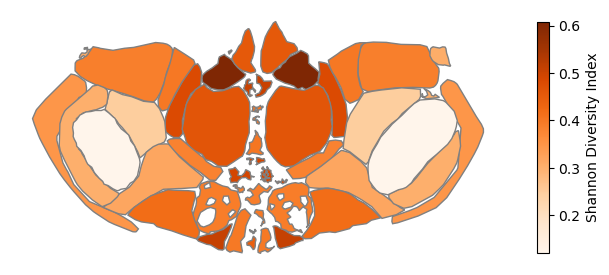

In [19]:
sections = ["1199651036", "1199651048", "1199651060"] #"1199651024",
print('Clusters')
cplot.plot_metrics_ccf(adata_neurons_ccf.obs, ccf_polygons_th_noZI, 
                       th_metrics.loc[ccf_names_noZI,'shannon_index_clusters'], 
                       sections=['1199651048'], cmap='Oranges',
                       highlight='all', cb_label='Shannon Diversity Index')

Supertypes
1199651048


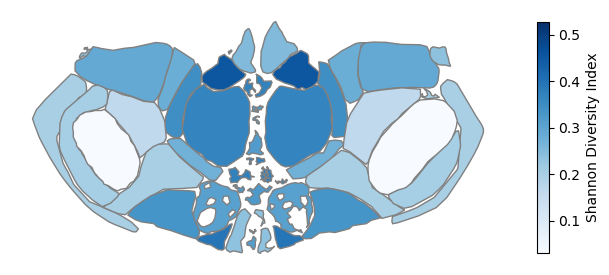

In [20]:
print('Supertypes')
cplot.plot_metrics_ccf(adata_neurons_ccf.obs, ccf_polygons_th_noZI, 
                       th_metrics.loc[ccf_names_noZI,'shannon_index_supertypes'], 
                       sections=['1199651048'], cmap='Blues',
                       highlight='all', cb_label='Shannon Diversity Index')

Subclasses
1199651048


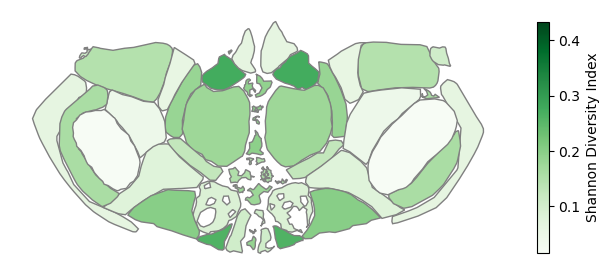

In [21]:
print('Subclasses')
cplot.plot_metrics_ccf(adata_neurons_ccf.obs, ccf_polygons_th_noZI, 
                       th_metrics.loc[ccf_names_noZI,'shannon_index_subclasses'], 
                       sections=['1199651048'], cmap='Greens',
                       highlight='all', cb_label='Shannon Diversity Index')

### Proportions as stacked bar graphs

In [44]:
# for each subregion, count the proportion of cells in each cluster/supertype/subclass
th_subregions = cpoly.CCF_TH_NAMES
ccf_cluster_counts = pd.DataFrame(index=th_subregions, columns=th_clusters)
ccf_supertype_counts = pd.DataFrame(index=th_subregions, columns=th_supertypes)
ccf_subclass_counts = pd.DataFrame(index=th_subregions, columns=th_subclasses)
for subregion, df in adata_neurons_ccf.obs.groupby('CCF_acronym'):
    # clusters
    cluster_counts = df.cluster_label.value_counts()
    ccf_cluster_counts.loc[subregion, 
                           cluster_counts.index] = cluster_counts.values / len(df)

    # supertypes
    supertype_counts = df.supertype_id_label.value_counts()
    ccf_supertype_counts.loc[subregion, 
                             supertype_counts.index] = supertype_counts.values / len(df)

    # subclasses
    subclass_counts = df.subclass_id_label.value_counts()
    ccf_subclass_counts.loc[subregion, 
                            subclass_counts.index] = subclass_counts.values / len(df)

#### TODO: Implement barchart w/ plotly

which will enable hovering over the bars to display the subclass/supertype/cluster to which it belongs

In [40]:
# display as a stacked bar graph
from colorcet import glasbey_light

def plot_stacked_barplot(df, taxonomy_level, legend=True):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
    colors = sns.color_palette(glasbey_light, n_colors=len(df.columns))
    df.plot(kind='bar', stacked=True, ax=axes, legend=legend, color=colors)
    if legend:
        axes.legend(loc='upper left', bbox_to_anchor=(0.05, -0.3), ncol=4)
    axes.set_xticklabels(df.index, rotation=90)
    axes.set_xlabel('CCF subregion')
    # axes.set_yticks([])
    axes.set_ylabel('proportion of cells in unique '+taxonomy_level)

    fig.subplots_adjust(hspace=0.1)
    
    # add text
    for i, subregion in enumerate(df.index):
        n_nonzero = (df.loc[subregion]>0).sum()
        axes.text(i, 1.01, n_nonzero, horizontalalignment='center')
    plt.show()

#### Subclasses

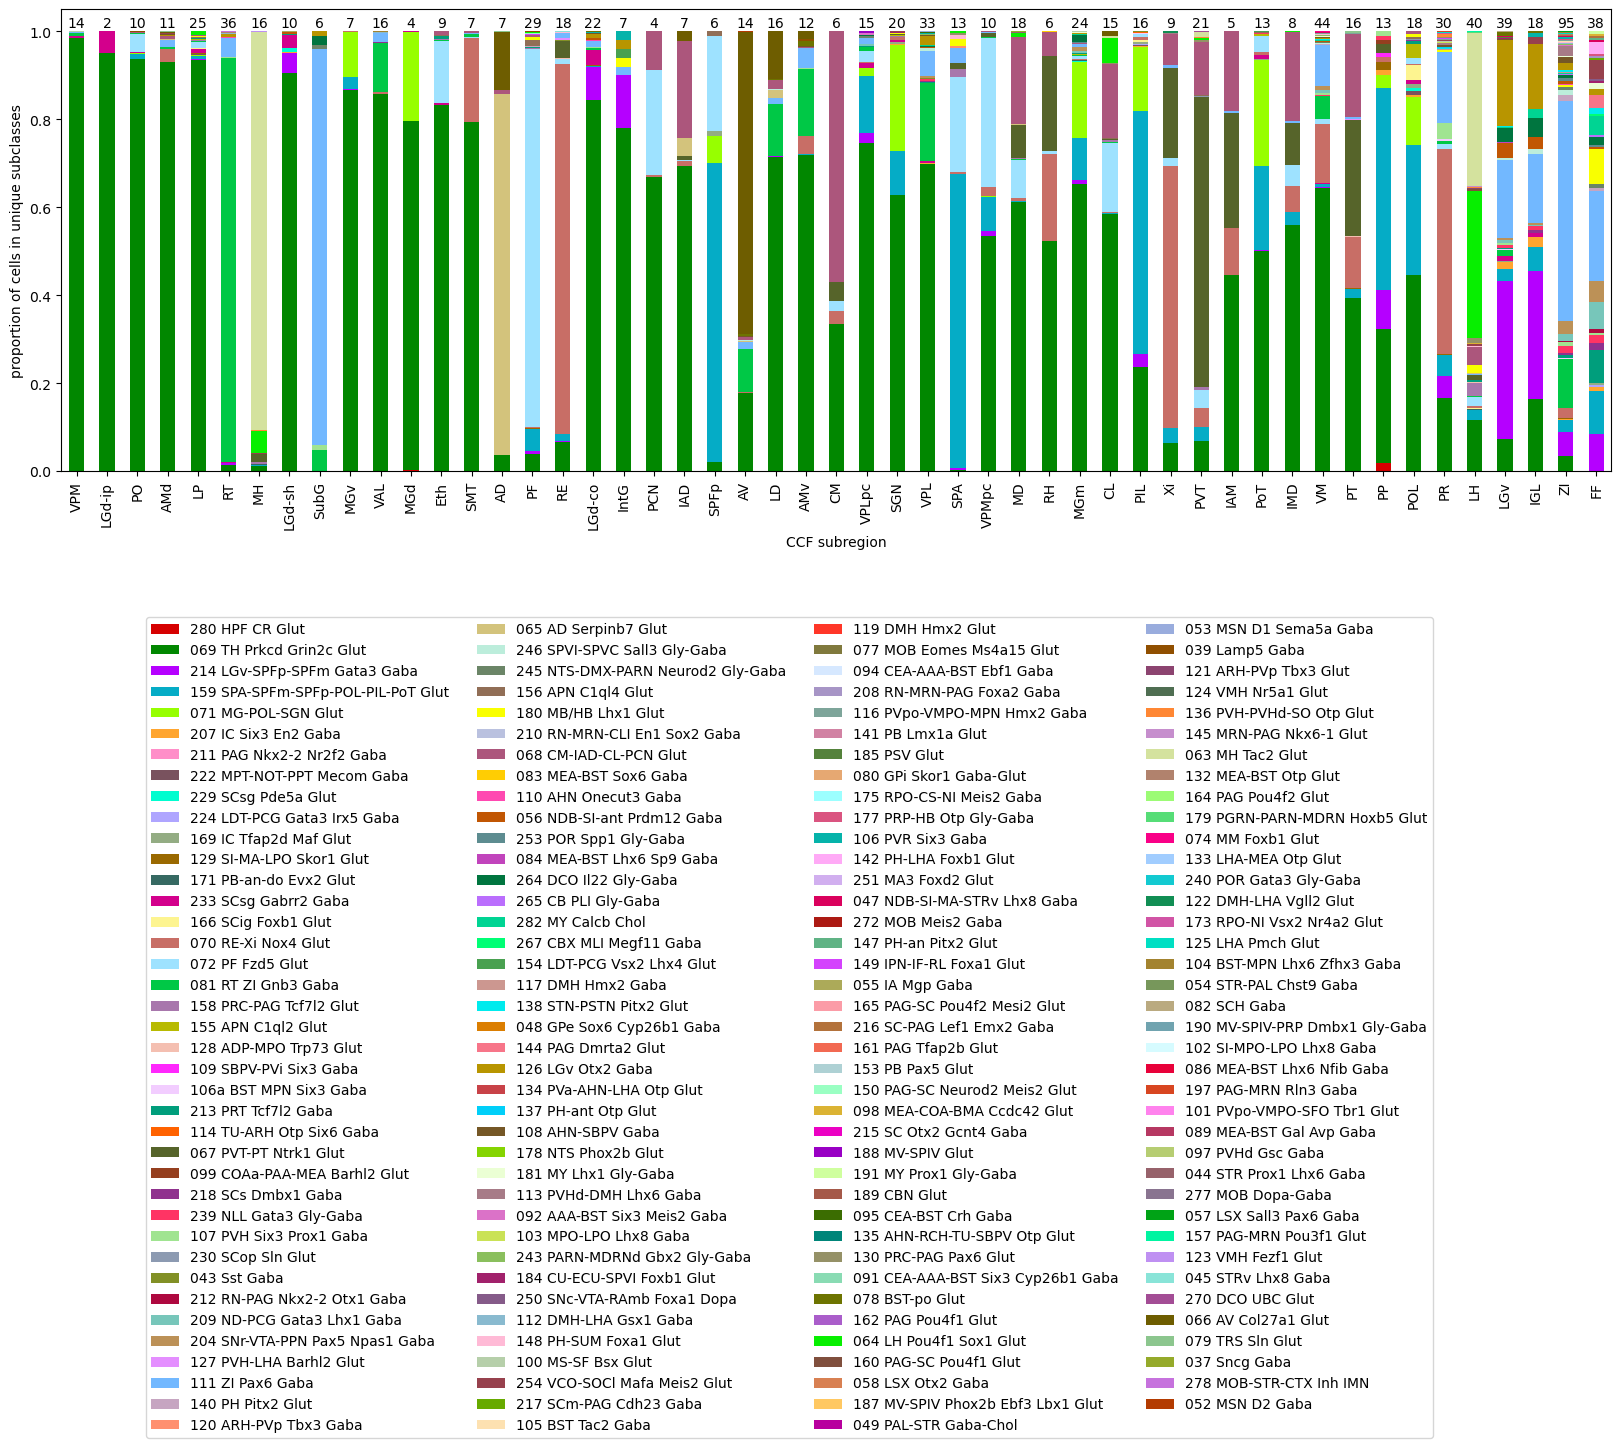

In [41]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.sort_values(by='shannon_index_subclasses', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_subclass_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'subclasses', legend=True)

#### Supertypes

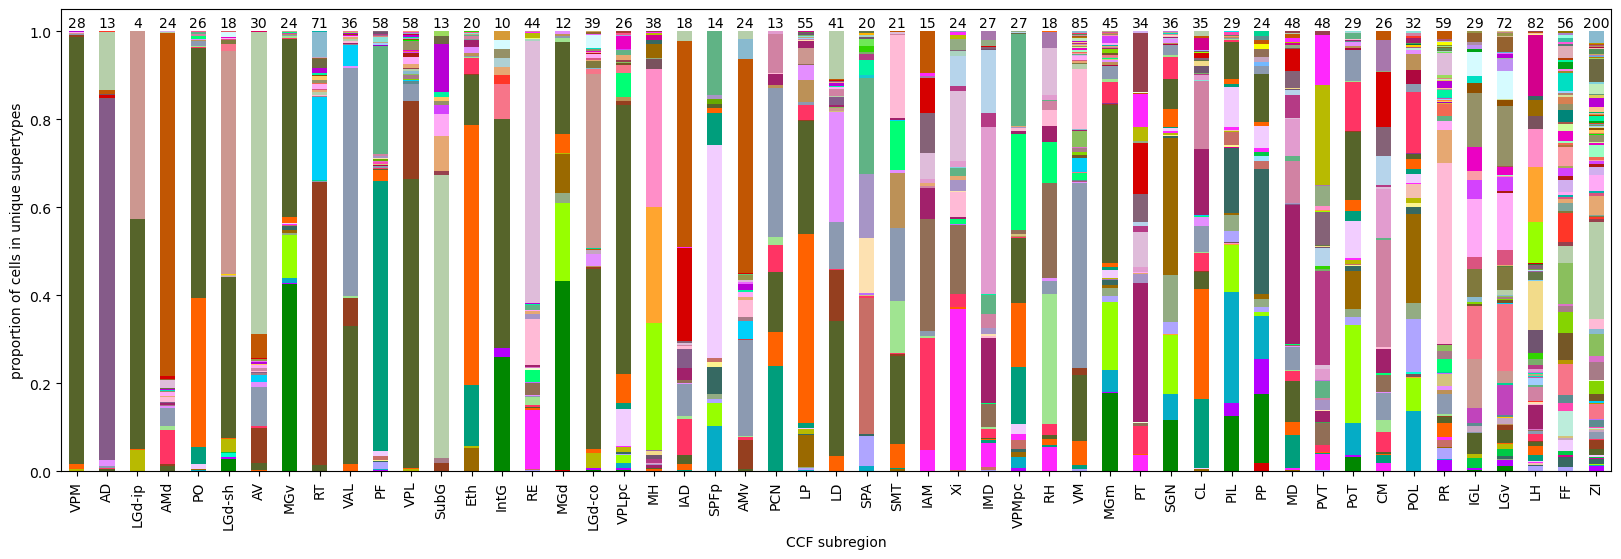

In [42]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.sort_values(by='shannon_index_supertypes', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_supertype_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'supertypes', legend=False)

#### Clusters

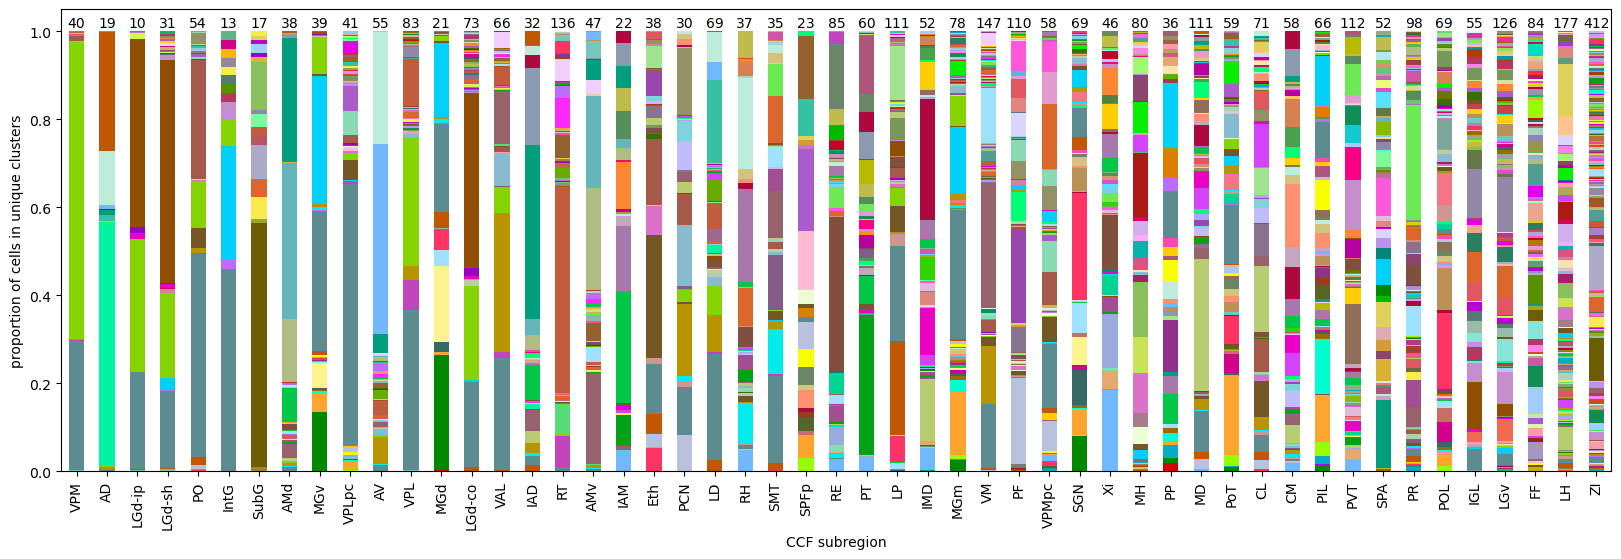

In [43]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.sort_values(by='shannon_index_clusters', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_cluster_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'clusters', legend=False)

# Per Cluster/Supertype/Subclass Metrics (neurons only)

## TODO: Dispersion of clusters/supertypes across nuclei

i.e. grab a cluster that dominates in one nucleus (e.g. 1133 in MD) and ask how dispersed it is across the whole thalamus. Ideally, a linear metric, such that you could ask what the dispersion is for all clusters to see which ones seem to be more compact and which are more shared

I *think* this is going to have to be done on hemispheres, rather than the whole brain. Most existing tools I'm finding are not able to account for symmetries.

Likely going to borrow from some of ArcGIS's standard toolboxes
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-standard-distance-spatial-statistic-works.htm

Or other satellite imagery methods:
- https://www.tandfonline.com/doi/full/10.1080/17538947.2018.1474957

# Neighborhood metrics

Single neuron tracing in the MD (shown in weekly U19 on Fri 7/28/23) illustrates two things:
1. Some *neighboring* soma have *distinct* projection patterns
2. Some *distant* soma have *very similar* projection patterns

Jayaram's interpretation is that \#1 is surprising given gene expression in the MD.

But I don't think that's the correct interpretation, especially in the MD! 
- MD contains a large diversity of cell types, many of which show salt-and-pepper sprinkling throughout the MD.
- At the very least, we don't have our MERFISH data analyzed in the right way to say whether or not the single neuron data is surprising/unexpected
- They really need their mFISH data to say this for certain

## TODO: most likely/common neighboring cell type metric

"most common / most likely neighbor" metrics for cells
- How likely are you to find a cell with (a) the same or (b) a different transcriptomic type right next to your cell of interest?
- What's the average fraction of nearest neighbors that are the same? different?
- How many non-self cell types are represented in the nearest neighbors?
- Do these metrics change from nucleus to nucleus? i.e. do cells in the MD have more diverse neighbors than, say, AD? (shannon index might suggest that they do)